# Traffic Flow Forecasting

## Objective 

Our main goal is to **forecast twelve-hours of traffic flow in a major U.S. metropolitan area** and model interactions across a network of roadways, using a time series labelled dataset with both location coordinates and a direction of travel.

Dataset from: https://www.kaggle.com/competitions/tabular-playground-series-mar-2022/overview

## Dataset Descriptions
`train.csv` : the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991. 
- row_id: a unique identifier for this instance 
- time: the 20-minute period in which each measurement was taken 
- x: the east-west midpoint coordinate of the roadway 
- y: the north-south midpoint coordinate of the roadway 
- direction: the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel congestion 
- congestion: levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.
`test.csv` : the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.

`sample_submission.csv` : a sample submission file in the correct format.

In [ ]:
!pip install kaggle

     |████████████████████████████████| 58 kB 8.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=47ccd98884b3887edc9846e70ea3dbff1e34d9bde574fc36ee2cee8916e9eb5a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
!cp /work/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tabular-playground-series-mar-2022

  0%|                                               | 0.00/4.71M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 4.71M/4.71M [00:00<00:00, 103MB/s]


In [ ]:
!unzip /work/tabular-playground-series-mar-2022.zip -d /work/dados/

Archive:  /work/tabular-playground-series-mar-2022.zip
  inflating: /work/dados/sample_submission.csv  
  inflating: /work/dados/test.csv    
  inflating: /work/dados/train.csv   


In [ ]:
# imports

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import datetime

### Loading the data

In [ ]:
train_df = pd.read_csv('/work/ML-projects/MSc-ML/traffic-flow-forecasting/dados/train.csv')
test_df = pd.read_csv('/work/ML-projects/MSc-ML/traffic-flow-forecasting/dados/test.csv')

In [ ]:
train_df.head(10)

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
5,5,1991-04-01 00:00:00,0,1,SB,58
6,6,1991-04-01 00:00:00,0,1,WB,26
7,7,1991-04-01 00:00:00,0,2,EB,31
8,8,1991-04-01 00:00:00,0,2,NB,49
9,9,1991-04-01 00:00:00,0,2,SB,46


### Data Understanding

#### Roadway features 

Altogether, there are 12 unique roadways, 8 directions and 65 combinations of roadway with direction.

In [ ]:
# unique roadways

roadways = train_df[['x', 'y']].drop_duplicates()

print(str(roadways) + '\n\nNumber of unique roadways :', len(roadways))

    x  y
0   0  0
3   0  1
7   0  2
11  0  3
17  1  0
23  1  1
27  1  2
33  1  3
39  2  0
43  2  1
51  2  2
59  2  3

Number of unique roadways : 12


In [ ]:
print('Unique directions:', train_df.direction.unique())

Unique directions: ['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


In [ ]:
road_dir = train_df[['x', 'y', 'direction']].drop_duplicates()
print('Number of unique roadways with directions: ', len(road_dir))

Number of unique roadways with directions:  65


Visualizing the geographical map with roadways (points) and directions (lines).

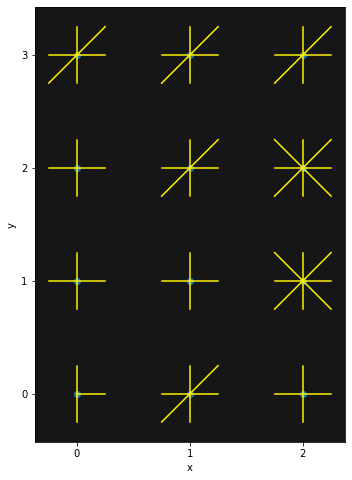

In [ ]:
# creating a direction dictionary

dir_dict = {'EB': (1, 0), 'NB': (0, 1), 'SB': (0, -1), 'WB': (-1, 0), 'NE': (1, 1), 'SE': (-1, 1), 'NW': (1, -1), 'SW': (-1, -1)}

# setting plot background

plt.rcParams['axes.facecolor'] = '#161617' # blue

# plotting image

plt.figure(figsize=(8, 8))
plt.scatter(roadways.x, roadways.y)
plt.gca().set_aspect('equal')

# ploting the unique roadways (points) and the unique roadways with directions (lines)

for _, x, y, d in road_dir.itertuples():
    dx, dy = dir_dict[d]
    dx, dy = dx/4, dy/4
    plt.plot([x, x+dx], [y, y+dy], color='#fff200')

# only integer labels
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) 

plt.xlabel('x')
plt.ylabel('y')
plt.show()

Observations: 
- Knowing that congestion is measured for certain points and directions in space, we could assume the existence of a congestion correlation between two or more roadways, e.g. congestion at (1, 1, westbound) should be correlated with past congestion at (0, 1, ...) or vice-versa.
- However, itsn't clear if we need the geography at all. A simple approach for the competition could be ignoring the geography and creating 65 independent time series. Or doing one-hot encoding the 65 x,y/direction combinations and using them as features.
- Another unclear aspect is how to know if the y axis grows from top to bottom or bottom to top.


#### Time feature

In the training dataset there are **13059** time values. 
Also, as we know, there are 65 combinations of roadways with directions, so 13059 * 65 equals to **848835 examples**  of training data.
 


In [ ]:
#converting to time type
train_df["time"] = pd.to_datetime(train_df["time"])

unique_times = train_df.time.unique()
print("Number of unique times in training dataset:", len(unique_times))

Number of unique times in training dataset: 13059


All of `train` timestamps are between 1991-04-01 00:00 and 1991-09-30 11:40. The `test` timestamps cover the half day from 1991-09-30 12:00 through 1991-09-30 23:40, which is a Monday.

In [ ]:
# diffence about sequences of timestamps
np.diff(unique_times)

array([1200000000000, 1200000000000, 1200000000000, ..., 1200000000000,
       1200000000000, 1200000000000], dtype='timedelta64[ns]')

The difference between successive training timestamps is almost always 20 minutes. However there are **28 timestamps** that don't follow this same distribuition (listed below).

In [ ]:
# from all the unique times, getting all examples which the discrete difference are diferent from 20 min (1200000000000 ns) 

unique_times[1:][np.diff(unique_times) != np.diff(unique_times)[0]]

array(['1991-04-20T19:20:00.000000000', '1991-04-24T06:20:00.000000000',
       '1991-05-04T22:00:00.000000000', '1991-05-18T19:40:00.000000000',
       '1991-05-31T03:20:00.000000000', '1991-06-15T20:40:00.000000000',
       '1991-07-18T20:20:00.000000000', '1991-07-20T19:40:00.000000000',
       '1991-08-08T14:20:00.000000000', '1991-08-16T19:00:00.000000000',
       '1991-08-17T19:40:00.000000000', '1991-08-23T15:20:00.000000000',
       '1991-08-23T16:00:00.000000000', '1991-08-27T12:00:00.000000000',
       '1991-08-29T03:40:00.000000000', '1991-08-29T09:20:00.000000000',
       '1991-08-30T14:20:00.000000000', '1991-08-31T11:00:00.000000000',
       '1991-09-12T03:20:00.000000000', '1991-09-12T08:20:00.000000000',
       '1991-09-12T11:00:00.000000000', '1991-09-17T14:00:00.000000000',
       '1991-09-18T14:40:00.000000000', '1991-09-19T03:20:00.000000000',
       '1991-09-19T08:40:00.000000000', '1991-09-21T22:00:00.000000000',
       '1991-09-24T09:40:00.000000000', '1991-09-24

In [ ]:
# example case: from 1991-09-12 06:20:00 to 1991-09-12 08:20:00

train_df[765795:]

,row_id,time,x,y,direction,congestion
765795,765795,1991-09-12 06:20:00,1,2,SB,68
765796,765796,1991-09-12 06:20:00,1,2,SW,75
765797,765797,1991-09-12 06:20:00,1,2,WB,56
765798,765798,1991-09-12 06:20:00,1,3,EB,34
765799,765799,1991-09-12 06:20:00,1,3,NB,77
...,...,...,...,...,...,...
848830,848830,1991-09-30 11:40:00,2,3,NB,54
848831,848831,1991-09-30 11:40:00,2,3,NE,28
848832,848832,1991-09-30 11:40:00,2,3,SB,68
848833,848833,1991-09-30 11:40:00,2,3,SW,17


Observations so far:

- There are missing values, and our model will have to deal with a noncontiguous time series. This part is goin to be more discussed in the feature engineering stage.
- As the test set is restricted to one Monday afternoon, so perhaps it won't be necessary train in all days of the week.

#### Congestion Label

Congestion is the dataset label and has **integers** numbers variating between 1 to 100. Because most regression algorithms output float values, we could probably clip and round the regression output. 

ref: https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/301249

<AxesSubplot:>

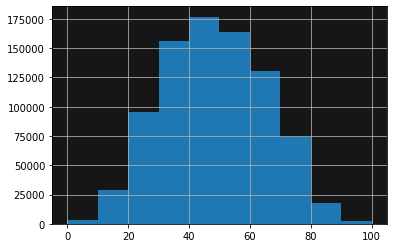

In [ ]:
train_df['congestion'].hist()

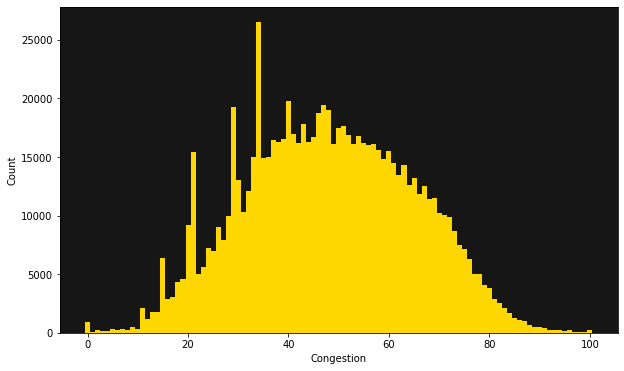

In [ ]:
# overall congestion histogram

plt.figure(figsize=(10, 6))
plt.bar(range(101), train_df.congestion.value_counts().sort_index(), width=1,
        color='gold')
plt.ylabel('Count')
plt.xlabel('Congestion')
plt.show()

Because of there are prominent values like 15, 20, 21, 29, 34, it could be a problem for the regressor learn this distribution.


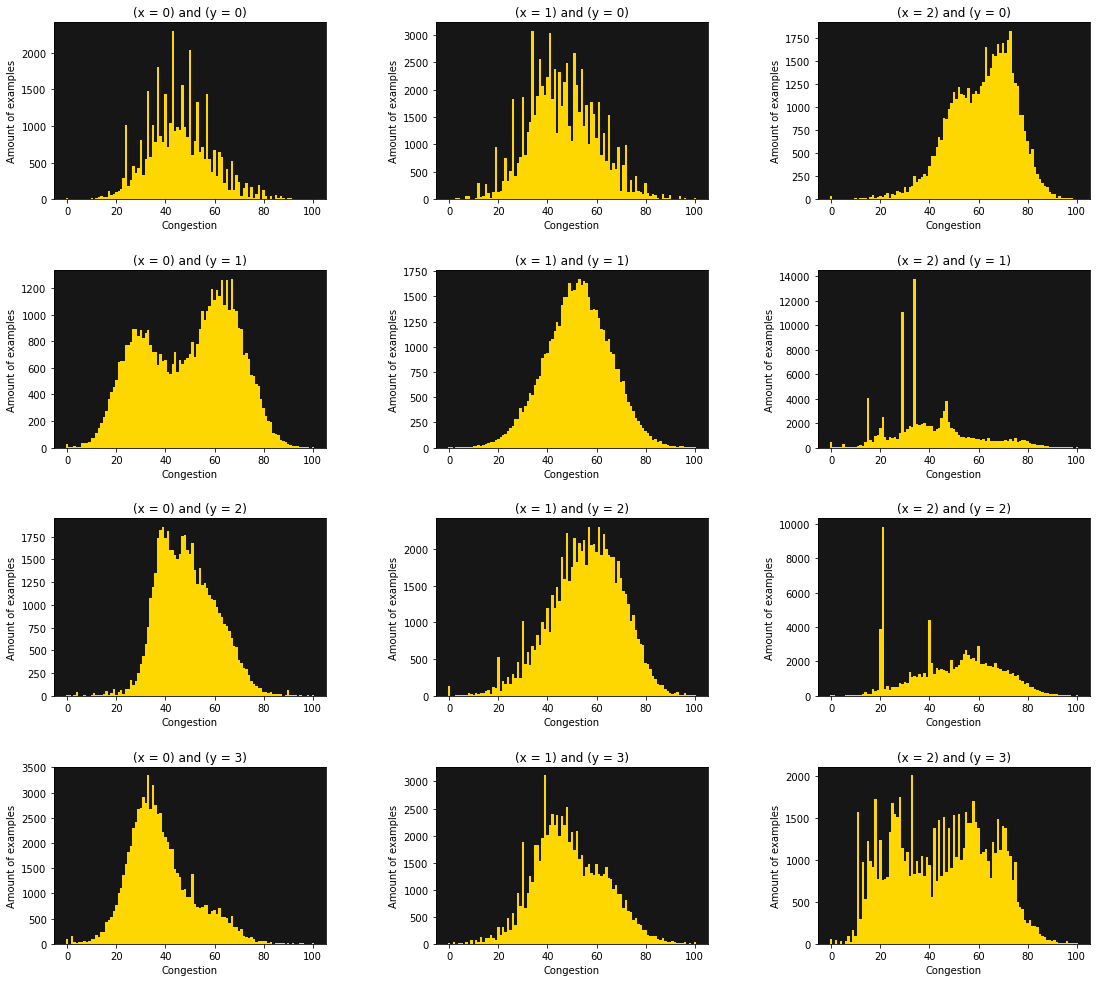

In [ ]:

plt.subplots(4, 3, sharex=True, sharey=True, figsize=(18, 16))
#fig, axes = plt.subplots(nrows=4, ncols=3)
for y in range(4):
    for x in range(3):
        #plt.subplot(4, 3, x+1)
        plt.subplot2grid((4,3), (y,x))
        vc = train_df[(train_df.x == x) & (train_df.y == y)].congestion.value_counts().sort_index()
        plt.bar(vc.index, vc, width=1,
                color='gold')
        plt.ylabel('Amount of examples')
        plt.xlabel('Congestion')
        plt.title(f"(x = {x}) and (y = {y})")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

Notice that congestions like 15, 29 and 34 are a particularity of the roadway with x = 2 and y = 1. Roadway x = 2 and y = 2 seems also a bit imbalanced.

At this point, we could conclude that **a simple linear regressor won't be able to model the data**. We could use a model like decision trees that can make the non-linear separation.

#### Congestion and Time

Space to search and analyze patterns of congestion through days of the week. 

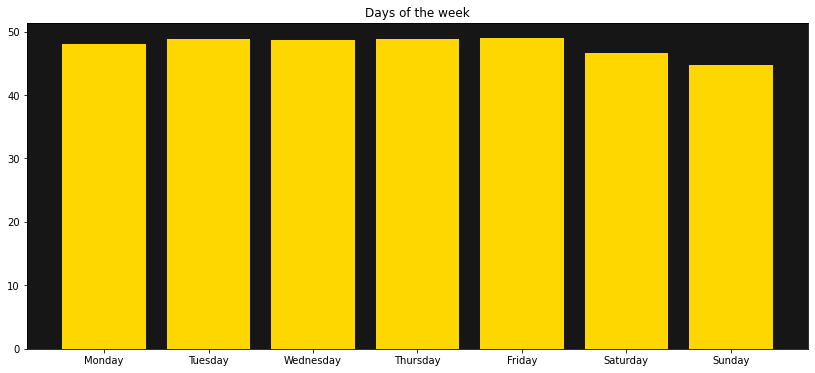

In [ ]:
cong_time = train_df.groupby(train_df.time.dt.dayofweek).congestion.mean()
plt.figure(figsize=(14, 6))
plt.title('Days of the week')
plt.bar(cong_time.index, cong_time, color='gold')
plt.xticks(ticks=cong_time.index, labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

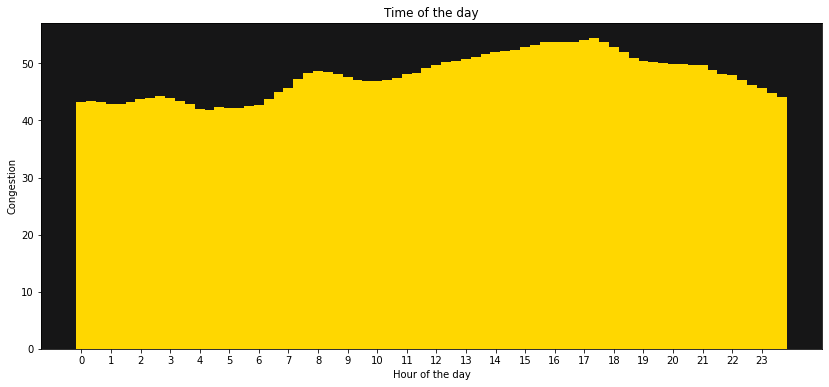

In [ ]:
cong_day = train_df.groupby(train_df.time.dt.hour + train_df.time.dt.minute/60).congestion.mean()
plt.figure(figsize=(14, 6))
plt.title('Time of the day')
plt.bar(cong_day.index, cong_day, color='gold', width=0.34)
plt.xticks(range(24))
plt.xlabel('Hour of the day')
plt.ylabel('Congestion')
plt.show()

The graphs show that there is a weekly pattern with low congestion on the weekend and also, a daily pattern with a morning peak and a higher peak in the late afternoon.

We also should analyze congestion at the holidays of this period, like Fourth of July and so on. 

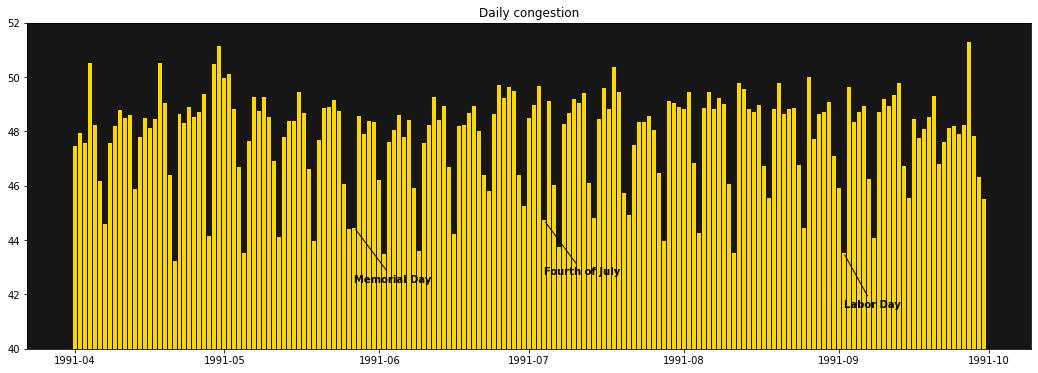

In [ ]:
temp = train_df.groupby(train_df.time.dt.date).congestion.mean()
plt.figure(figsize=(18, 6))
plt.title('Daily congestion')
plt.bar(temp.index, temp, color='#ffd700')
plt.ylim(40, 52)
for holiday_name, month, day in [('Memorial Day', 5, 27), ('Fourth of July', 7, 4), ('Labor Day', 9, 2)]:
    date = datetime.date(1991, month, day)
    plt.annotate(holiday_name,
                 (np.datetime64(date), temp.loc[date]),
                 xytext=(np.datetime64(date), temp.loc[date]-2),
                 arrowprops={'arrowstyle': '-'},
                 weight='bold',
                 color='k')
plt.show()

Only Memorial Day it's on the weekend. The 4th of July (which was a Thursday) has meager traffic, and the same occurs with Labor day that happens on a Monday.

Holidays reference: https://www.timeanddate.com/calendar/?year=1991&country=1

Observations:

- Thus, these outliers can be a considerable problem if we want our model to learn this data distribution. A simple approach could be dropping all the holidays before training.
- Overall, there seem to be weeks with high traffic and weeks with low traffic, and there are yet no reasons why this happens.
- A good validation strategy will be important. Because we know that the test dataset is to predict the monday afternoon,perhaps we can use a few Monday afternoons as validation set.

todo: covariance matrix.

### Feature Engineering 

In [ ]:
def feature_eng(data):

    # add new columns/attributes to the train and test datasets

    # year, hour, week, minute, month, day of de week, day of year and is weekend

    data["time"] = pd.to_datetime(data["time"])
    data.time = pd.to_datetime(data.time)
    data['year'] = data.time.dt.year
    data['hour'] = data.time.dt.hour
    data['week'] = data.time.dt.isocalendar().week
    data['minute'] = data.time.dt.minute
    data['month'] = data.time.dt.month
    data['day_of_week'] = data.time.dt.day_name()
    data['is_afternoon'] = (data['time'].dt.hour > 12).astype('int')
    data['day_of_year'] = data.time.dt.dayofyear
    data['is_weekend'] = (data.time.dt.dayofweek >= 5).astype("int")
    data['yesterday'] = data.groupby(['x','y','direction','hour','minute'])['congestion'].transform(lambda x: x.shift(1))
    data = data.set_index('time')


    # transformation to get unique roadways with directions

    # x, y, direction -> road

    data['road'] = data['x'].astype(str) + data['y'].astype(str) + data['direction']

    le = LabelEncoder()
    data['road'] = le.fit_transform(data['road'])

    data = data.drop(['x', 'y', 'direction'], axis=1)




In [ ]:
test_df.head()

,row_id,x,y,direction,year,month,week,hour,minute,day_of_week,day_of_year,is_weekend
time,,,,,,,,,,,,
1991-09-30 12:00:00,848835,0,0,EB,1991,9,40,12,0,Monday,273,0
1991-09-30 12:00:00,848836,0,0,NB,1991,9,40,12,0,Monday,273,0
1991-09-30 12:00:00,848837,0,0,SB,1991,9,40,12,0,Monday,273,0
1991-09-30 12:00:00,848838,0,1,EB,1991,9,40,12,0,Monday,273,0
1991-09-30 12:00:00,848839,0,1,NB,1991,9,40,12,0,Monday,273,0


### Imputation

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3035cbe1-744b-40d6-9d24-00f96529caea' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>